In [1]:
import torch
from torch import nn
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [2]:
def display_gen_pred(imgs, size=(1, 28, 28)):
    img_unflat = imgs.detach().cpu().view(-1, *size)
    img_grid = make_grid(img_unflat[:25], nrow=5)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()
    
def display_loss_plot(gen_loss, disc_loss):
    plt.plot(range(len(gen_loss)), gen_loss, label='Generator loss')
    plt.plot(range(len(disc_loss)), disc_loss, label='Critic loss')
    plt.legend()
    plt.show()

In [3]:
def one_hot(labels, n_classes):
    enc_labels = nn.functional.one_hot(labels, n_classes).type(torch.float)
    return enc_labels

# Generator

In [4]:
class Generator(nn.Module):
    def __init__(self, z_chan=10, n_classes=10, img_chan=1, h_chan=64, device='cpu'):
        super(Generator, self).__init__()
        
        self.device = device
        self.z_chan = z_chan
        self.n_classes = n_classes
        self.inp_chan = z_chan + n_classes

        self.gen = nn.Sequential(
            self.layer(self.inp_chan, h_chan*4),
            self.layer(h_chan*4, h_chan*2, kernel_size=4, stride=1),
            self.layer(h_chan*2, h_chan),
            self.layer(h_chan, img_chan, kernel_size=4, last_layer=True)
        )

    def layer(self, in_chan, out_chan, kernel_size=3, stride=2, last_layer=False):
        if not last_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(in_chan, out_chan, kernel_size, stride),
                nn.BatchNorm2d(out_chan),
                nn.ReLU(),
            )
        return nn.Sequential(
            nn.ConvTranspose2d(in_chan, out_chan, kernel_size, stride),
            nn.Tanh(),
        )

    def forward(self, inp):
        inp = inp.view(len(inp), self.inp_chan, 1, 1)
        return self.gen(inp)

    def get_imgs(self, labels):
        noise = self.get_noise(len(labels))
        inp = self.add_labels_to_noise(noise, labels)
        return self(inp)

    def add_labels_to_noise(self, noise, labels):
        enc_labels = one_hot(labels, self.n_classes)
        return torch.cat((noise, enc_labels), dim=1)

    def get_noise(self, n_samples):
        return torch.randn(n_samples, self.z_chan, device=self.device)

# Discriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self, img_chan=1, h_chan=16, device='cpu'):
        super(Discriminator, self).__init__()

        self.device = device
        self.img_chan = img_chan

        self.disc = nn.Sequential(
            self.layer(self.img_chan, h_chan),
            self.layer(h_chan, h_chan*2),
            self.layer(h_chan*2, 10, last_layer=True),
        )

    def layer(self, in_chan, out_chan, kernel_size=4, stride=2, last_layer=False):
        if not last_layer:
            return nn.Sequential(
                nn.Conv2d(in_chan, out_chan, kernel_size, stride),
                nn.BatchNorm2d(out_chan),
                nn.LeakyReLU(negative_slope=0.2),
            )
        return nn.Sequential(
            nn.Conv2d(in_chan, out_chan, kernel_size, stride),
        )

    def forward(self, img):
        pred = self.disc(img)
        return pred.view(len(pred), -1)

# Data Loading & Initialization

In [6]:
Z_DIM=64
BATCH_SIZE=128
BETAS=(0.5, 0.999)
LR=0.0002
N_EPOCHS=100
DISPLAY_STEP=5
DEVICE='cpu'

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [8]:
criterion = nn.CrossEntropyLoss()

gen = Generator(Z_DIM, device=DEVICE).to(DEVICE)
disc = Discriminator(device=DEVICE).to(DEVICE)
gen_opt = torch.optim.Adam(gen.parameters(), lr=LR, betas=BETAS)
disc_opt = torch.optim.Adam(disc.parameters(), lr=LR, betas=BETAS)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

# Training

In [9]:
gen_losses = []
disc_losses = []

In [10]:
def train(dataloader, n_epochs, display_step):
    tqdm_obj = tqdm(range(1, n_epochs+1))
    no_of_batches = len(dataloader)

    for epoch in tqdm_obj:
        for i, (real_imgs, labels) in enumerate(dataloader, 0):
            tqdm_obj.set_postfix({ 'Batch': f'{i}/{no_of_batches}' })
            real_imgs = real_imgs.to(DEVICE)
            labels = labels.to(DEVICE)
            enc_labels = one_hot(labels, 10)
            cur_batch_size = len(real_imgs)

            # Discriminator training
            disc_opt.zero_grad()
            # Forward pass
            fake_imgs = gen.get_imgs(labels)
            fake_pred = disc(fake_imgs.detach())
            real_pred = disc(real_imgs)
            fake_loss = criterion(fake_pred, enc_labels)
            real_loss = criterion(real_pred, enc_labels)
            disc_loss = (fake_loss + real_loss) / 2
            # Backward pass
            disc_loss.backward(retain_graph=True)
            disc_opt.step()
            disc_losses.append(disc_loss.cpu().detach().numpy())

            # Generator training
            gen_opt.zero_grad()
            # Forward pass
            fake_imgs = gen.get_imgs(labels)
            pred = disc(fake_imgs)
            gen_loss = criterion(pred, enc_labels)
            # Backward pass
            gen_loss.backward()
            gen_opt.step()
            gen_losses.append(gen_loss.cpu().detach().numpy())

        if epoch % display_step == 0:
            print(f'After {epoch} epochs')
            display_loss_plot(gen_losses, disc_losses)
            display_gen_pred(gen.get_imgs(labels))

In [11]:
train(dataloader, N_EPOCHS, DISPLAY_STEP)

# Testing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


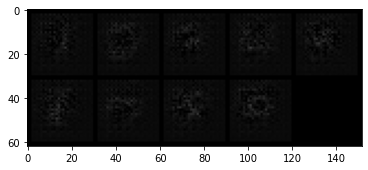

In [13]:
gen = gen.eval()
with torch.no_grad():
    imgs = gen.get_imgs(torch.Tensor([1,2,3,4,5,6,7,8,9]).type(torch.int64).to(DEVICE))
    display_gen_pred(imgs)